# Impact of Barren Plateaus Mitigation Strategy on the Performance of Quantum Neural Networks
*Training QNN treated with method 3 (Identity Blocks) of the BP mitigation strategy (IRIS)*

**Authors:**
- Jacob Cybulski and Thanh Nguyen

**Date:**
- June 2023

**Data:**
- Data = IRIS dataset with 99 examples
- Features = 4
- Target = {-1, 1}
- Iterations = 150
- Instance = 10

**Description:**
- This notebook aims to train 10 instances of a QNN initialised with identity blocks and produce averaged performance stats

In [1]:
import copy, math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torch import nn
from torch.nn import functional as F

from qiskit.utils import algorithm_globals
from qiskit.algorithms.optimizers import COBYLA, NELDER_MEAD, SLSQP, SPSA
from qiskit.opflow import Z, X, I, StateFn, PauliExpectation, Gradient, NaturalGradient, PauliSumOp
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN, OpflowQNN, CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.algorithms.classifiers import VQC, NeuralNetworkClassifier
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
# algorithm_globals.random_seed = 42

from IPython.display import clear_output

In [2]:
from Components.circuits import preTrainedBlockGenerator, featureMapGenerator, AnsatzGenerator, layerwise_training
from Components.data import iris, fetch_mnist, fetch_mnist_balanced
from Components.utils import plot_loss, score, parity, classification_callback, plot_objfn_range, result_to_objfun_dataframes, save_results
from Components.train import create_qnn, sampling_experiment, train, train_batch

In [3]:
DATA_SIZE = 500
FEATURE_DIM = 4
MAX_ITER = 120
MAX_INST = 10

MAX_REPS = 9
MIN_REPS = 1
MAX_IDENTITIES_BLOCKS = 2  # <---- Number of identity blocks, depth values of identity blocks is close to that of normal ansatz (5 qubits)
ENTANGLEMENT = 'linear'

GLOBAL_OPERATOR = PauliSumOp.from_list([('Z'*FEATURE_DIM, 1)])
LOCAL_OPERATOR = PauliSumOp.from_list([('I' * (FEATURE_DIM - 2)+'Z'*2, 1)])

LOG_PATH = './Logs-MNIST-v4'
METHOD_TAG = 'm2'

In [4]:
X_train, X_val, y_train, y_val = fetch_mnist_balanced(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Training set: 350 samples
Testing set: 150 samples
Number of features: 4
Classes:[0 1]; Encoded as: [-1  1]


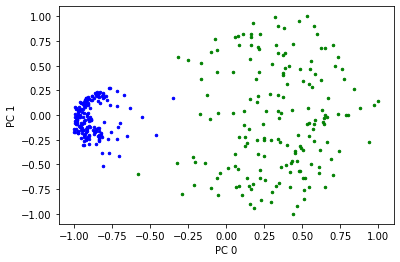

Blue: torch.Size([175])
Green: torch.Size([175])


In [5]:
# Plot dataset (only the first two args)
for x, y_target in zip(X_train_t, y_train_t):
    if y_target == 1:
        plt.plot(x[0], x[1], color="blue", marker=".", markersize=5)
    else:
        plt.plot(x[0], x[1], color="green", marker=".", markersize=5)
plt.xlabel('PC 0')
plt.ylabel('PC 1')
plt.show()

rows_b = np.where(np.array(y_train_t)==1)
rows_g = np.where(np.array(y_train_t)==-1)
print('Blue:', y_train_t[rows_b].size())
print('Green:', y_train_t[rows_g].size())

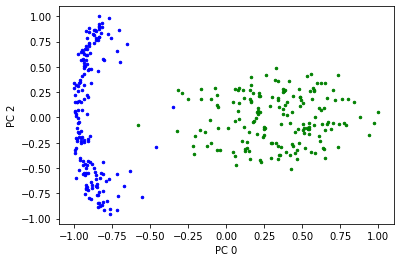

Blue: torch.Size([175])
Green: torch.Size([175])


In [6]:
# Plot dataset (only the first and the third arg)
for x, y_target in zip(X_train_t, y_train_t):
    if y_target == 1:
        plt.plot(x[0], x[2], color="blue", marker=".", markersize=5)
    else:
        plt.plot(x[0], x[2], color="green", marker=".", markersize=5)
plt.xlabel('PC 0')
plt.ylabel('PC 2')
plt.show()

rows_b = np.where(np.array(y_train_t)==1)
rows_g = np.where(np.array(y_train_t)==-1)
print('Blue:', y_train_t[rows_b].size())
print('Green:', y_train_t[rows_g].size())

In [7]:
def plot_method_data(data, title='Instance Losses', dlabel='inst#', xlabel='Loss', ylabel='Iteration'):
    # create figure and axis
    fig, ax = plt.subplots()
    fig.set_figheight(4)
    fig.set_figwidth(8)
    
    # setting the axis' labels
    ax.set_ylabel(xlabel)
    ax.set_xlabel(ylabel)

    # Plot data
    for i in range(len(data)):
        data[i].T.plot(ax=ax, label=f'inst# {i}', figsize=(5, 3))
    ax.legend([f'{dlabel} {i}' for i in range(len(data))])
    plt.title(title)
    plt.show()  

## Method 2 (Layerwise Learning)

In [8]:
from qiskit.primitives import Estimator # Statevector estimator

from os.path import exists
from os import makedirs

In [9]:
from qiskit import Aer, IBMQ
from qiskit.utils import QuantumInstance
from qiskit.opflow import CircuitSampler

backend = Aer.get_backend('statevector_simulator')
q_instance = QuantumInstance(
    backend, 
    shots = 100, 
    seed_simulator = 2718, 
    seed_transpiler = 2718,
    )

/tmp/ipykernel_436148/2278444018.py:6: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  q_instance = QuantumInstance(


In [10]:
feature_map = featureMapGenerator(FEATURE_DIM)
ansatz = AnsatzGenerator(FEATURE_DIM, reps=MAX_REPS, entanglement=ENTANGLEMENT)
qc = feature_map.compose(ansatz)

In [11]:
# To execute on multiple machines concurrently
# Select separate sub-lists of instance numbers and run
# Alternatively use range(MAX_INST) for all

m = METHOD_TAG
path = LOG_PATH

# for i in [0, 1, 2, 3, 4, 5, 6, 8, 9]: 
for i in [4, 5, 6]: 
    
    # Mark that the method's data has been saved
    if (exists(f'{path}/{m}')):
        print(f'Adding a new instance {i} of method {m}\n')
    else:
        makedirs(f'{path}/{m}')
        print(f'Creating the first instance {i} of method {m}\n')
        
    # Uses deprecated features in layerwise_training function
    initial_point = layerwise_training(ansatz, MAX_REPS, COBYLA(maxiter=50), q_instance)

    # By default this will run as a local simulation
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=Estimator(),
        observables=GLOBAL_OPERATOR,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )

    model = TorchConnector(qnn, initial_weights=initial_point)

    loss_function = nn.L1Loss() # MSELoss()
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

    model, losses, accuracy_train, accuracy_test, weights = train(
        model, 
        MAX_ITER, 
        X_train_t,
        y_train_t,
        X_val_t,
        y_val_t,
        optimizer = optimizer, 
        loss_function = loss_function
        )

    pd.DataFrame(losses).astype('float').to_csv(f'{path}/{m}/{m}-{i}-LossFunction.csv')
    pd.DataFrame(accuracy_train).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Scores-Train.csv')
    pd.DataFrame(accuracy_test).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Scores-Test.csv')
    pd.DataFrame(weights).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Weights.csv')
    
    # Mark that the method's data has been saved
    if (exists(f'{path}/{m}/{m}-Method.csv')):
        f = open(f'{path}/{m}/{m}-Method.csv', 'a')
    else:
        f = open(f'{path}/{m}/{m}-Method.csv', 'w')
        f.write(f'{m},Instance,Max Inst,Examples,Features,Iterations\n')
    f.write(f',{i},{MAX_INST},{DATA_SIZE},{FEATURE_DIM},{MAX_ITER}\n')
    f.close()
    
    clear_output(wait=True)

Adding a new instance 6 of method m2

Epoch      Loss                 Train Accuracy   Test Accuracy   
[ 0 ]      0.9962199926376343   0.50286          0.55333         
[ 10 ]     0.8011800050735474   0.85714          0.79333         
[ 20 ]     0.7211700081825256   0.87429          0.89333         
[ 30 ]     0.6771799921989441   0.92286          0.92667         
[ 40 ]     0.6546099781990051   0.93143          0.95333         
[ 50 ]     0.6546400189399719   0.92             0.93333         
[ 60 ]     0.6456999778747559   0.92571          0.93333         
[ 70 ]     0.6433200240135193   0.93714          0.93333         
[ 80 ]     0.6447200179100037   0.92571          0.92667         
[ 90 ]     0.6410800218582153   0.92571          0.93333         
[ 100 ]    0.638729989528656    0.92571          0.93333         
[ 110 ]    0.6386299729347229   0.92571          0.93333         
[ 119 ]    0.6396600008010864   0.93143          0.94667         


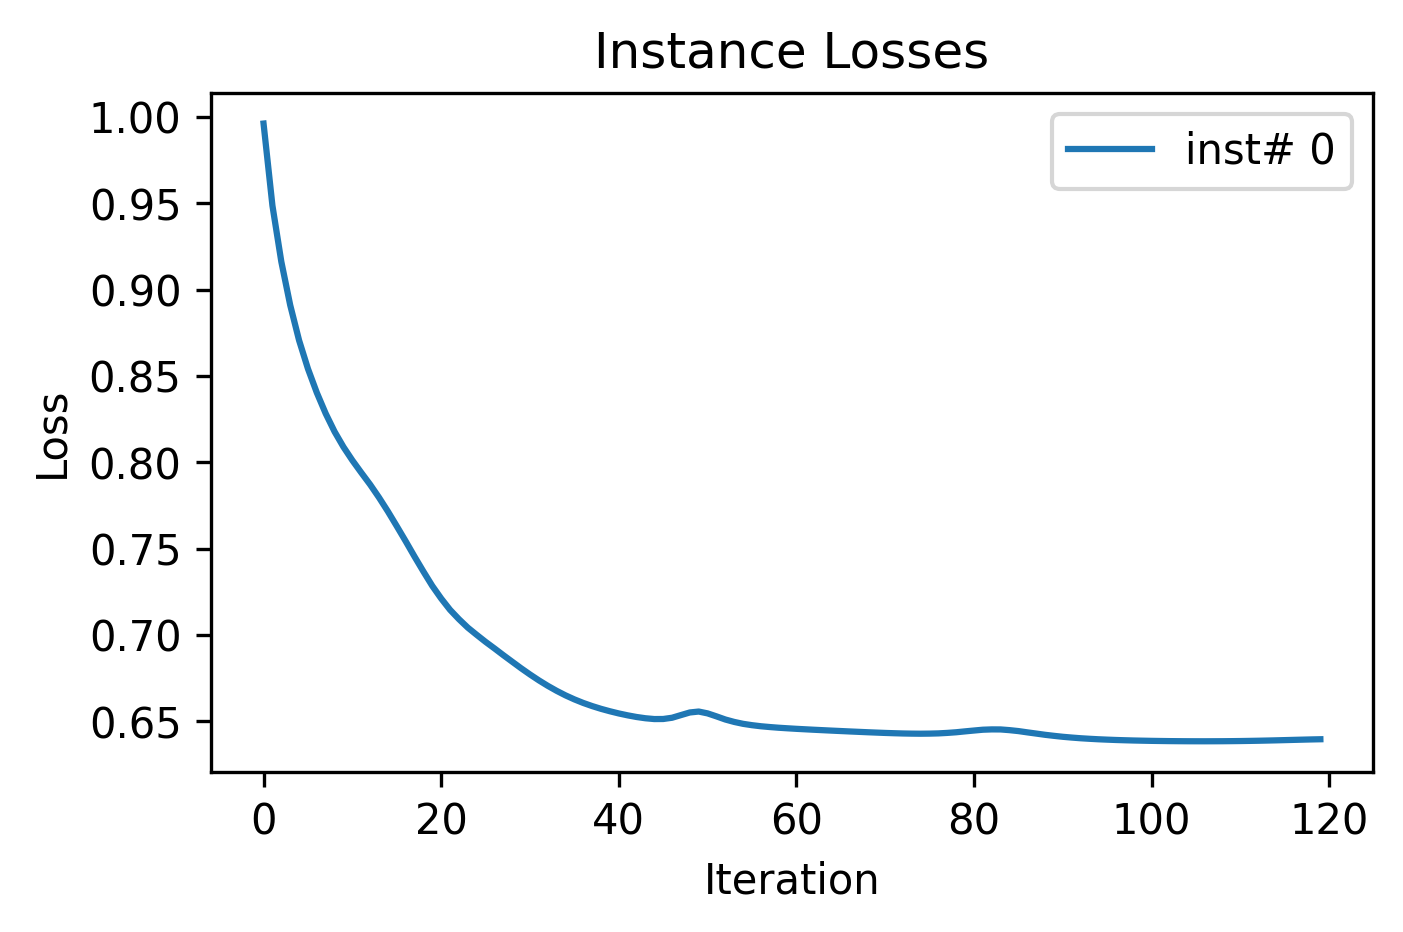

In [12]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Plot the loss of the last saved instance
plot_method_data([pd.DataFrame(losses).astype('float').T])

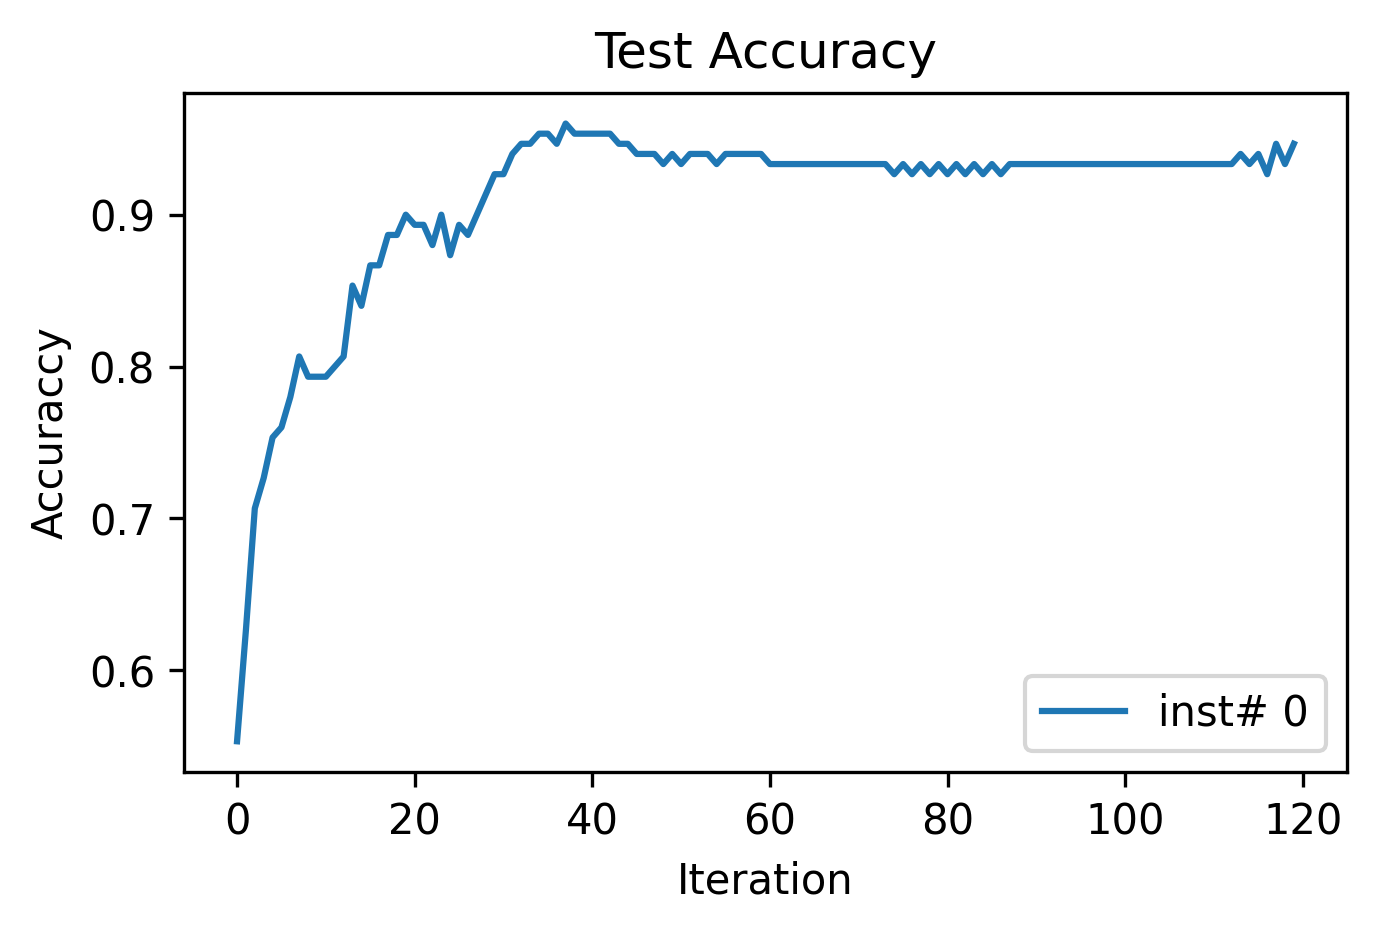

In [13]:
# Plot the loss of the last saved instance
plot_method_data([pd.DataFrame(accuracy_test).astype('float').T],
                title='Test Accuracy', dlabel='inst#', xlabel='Accuraccy', ylabel='Iteration')

In [14]:
!pip list | grep qiskit

qiskit                        0.43.0
qiskit-aer                    0.12.0
qiskit-dynamics               0.4.0
qiskit-experiments            0.5.2
qiskit-finance                0.3.4
qiskit-ibm-experiment         0.3.1
qiskit-ibm-runtime            0.9.4
qiskit-ibmq-provider          0.20.2
qiskit-machine-learning       0.6.1
qiskit-nature                 0.6.0
qiskit-optimization           0.5.0
qiskit-terra                  0.24.0


In [15]:
!pip list | grep torch

torch                         2.0.1
torchsummary                  1.5.1
